In [116]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import scienceplots
# --- 1. PARSING AND LOADING FUNCTIONS ---

def parse_experiment_name(name: str) -> dict:
    """Parses the detailed experiment folder name into a dictionary of parameters."""
    pattern = re.compile(
        r"(?P<surrogate>GP)-"
        r"(?P<acquisition>UCB|EI)_q(?P<quantile_level>[\d.]+)-"
        r"(?P<n_initial>\d+)init-"
        r"recal_(?P<method>[\w_.-]+)-"
        r"noisify_(?P<noisify>True|False)"
    )
    match = pattern.match(name)
    if not match:
        return {}
    return match.groupdict()

def load_all_results(base_path: str = "results_synth_data") -> pd.DataFrame:
    """
    Finds all 'metrics.json' files, parses their paths, and loads them into a pandas DataFrame.
    """
    base_path = Path(base_path)
    if not base_path.is_dir():
        print(f"Error: Directory not found at '{base_path.resolve()}'")
        return pd.DataFrame()

    # Use glob to find all metrics.json files recursively
    metric_files = list(base_path.glob('**/metrics.json'))
    
    all_results = []
    print(f"Found {len(metric_files)} result files. Parsing...")
    for path in tqdm(metric_files):
        try:
            # The path parts give us the folder names
            # e.g., ('results_synth_data', 'GP-EI...', 'Ackley10D', 'seed_0', 'metrics.json')
            experiment_name = path.parts[-4]
            problem_name = path.parts[-3]
            seed_str = path.parts[-2]
            
            # Parse the parameters from the folder names
            params = parse_experiment_name(experiment_name)
            params['problem'] = problem_name
            params['seed'] = int(seed_str.split('_')[-1])
            
            # Load the metrics data
            with open(path, 'r') as f:
                metrics = json.load(f)
            
            # Combine parameters and metrics into a single record
            params.update(metrics)
            all_results.append(params)
        except (IndexError, ValueError) as e:
            print(f"Warning: Could not parse path '{path}'. Error: {e}")
            continue
            
    return pd.DataFrame(all_results)

# --- 2. AGGREGATION FUNCTION ---

def aggregate_metrics(df: pd.DataFrame, metrics_to_process: list) -> pd.DataFrame:
    """
    Groups the results by experiment and calculates the mean and standard deviation
    for specified metrics across all seeds.
    """
    if df.empty:
        return pd.DataFrame()
        
    # Define the columns that uniquely identify an experiment
    grouping_keys = [
        'problem', 'surrogate', 'acquisition', 'quantile_level', 
        'n_initial', 'method', 'noisify'
    ]
    
    # Ensure all grouping keys are in the DataFrame columns
    missing_keys = [key for key in grouping_keys if key not in df.columns]
    if missing_keys:
        print(f"Error: Missing grouping keys in DataFrame: {missing_keys}")
        return pd.DataFrame()

    print("Aggregating results across seeds...")
    
    aggregated_data = []
    
    grouped = df.groupby(grouping_keys)
    
    for name, group in tqdm(grouped):
        agg_row = dict(zip(grouping_keys, name))
        
        for metric in metrics_to_process:
            # Stack the lists from all seeds into a 2D numpy array
            # Each row is a seed, each column is an iteration
            metric_array = np.array(group[metric].tolist())
            num_seeds = metric_array.shape[0]
            # Calculate mean and std across seeds (axis=0)
            agg_row[f'{metric}_mean'] = np.mean(metric_array, axis=0)
            agg_row[f'{metric}_std'] = np.std(metric_array, axis=0)
            agg_row[f'{metric}_sem'] = np.std(metric_array, axis=0) / np.sqrt(num_seeds)
            
        aggregated_data.append(agg_row)
        
    return pd.DataFrame(aggregated_data)

# --- 3. PLOTTING FUNCTION ---

def plot_metric_comparison(
    agg_df: pd.DataFrame, 
    problem_name: str, 
    metric: str,
    n_initial: int = 10,
    noisify: bool = True,
    acquisition: str = "UCB",
    quantile_level: float = 0.95,
    methods_to_plot: list = None,
    save_path: str = None
):
    """
    Plots the mean and standard deviation of a metric for a given problem,
    comparing all recalibration methods.
    """
    
    # Filter the aggregated dataframe for the specific experiment settings
    subset_df = agg_df[
        (agg_df['problem'] == problem_name) &
        (agg_df['n_initial'] == str(n_initial)) &
        (agg_df['noisify'] == str(noisify)) &
        (agg_df['acquisition'] == acquisition) &
        (agg_df['quantile_level'] == str(quantile_level))
    ].sort_values(by='method') # Sort for consistent plot colors
    
    if methods_to_plot:
        subset_df = subset_df[subset_df['method'].isin(methods_to_plot)]

    # Sort for consistent plot colors
    subset_df = subset_df.sort_values(by='method')
    
    if subset_df.empty:
        print(f"No data found for problem '{problem_name}' with the specified settings.")
        return
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(tight_layout=True, figsize=(10, 6))
    ax.grid(False)
    #tick_width = 1.5
    #border_width = 1.5

    # Set linewidth for the spines (borders)
    #for spine in ax.spines.values():
    #    spine.set_linewidth(border_width)
    #ax.tick_params(width=tick_width)
    
    legend_labels = []
    
    label_map = {
        'None': 'BO',
        'UNIBOv1': 'Kuleshov 2018 (with moment estimation)',
        'UNIBOv2': 'Kuleshov 2018 (with quantile estimation)',
        f'ONLINEv1_e05': 'Deshpande 2024 (with moment estimation and $\eta$=0.5)',
        f'ONLINEv1_e005': 'Deshpande 2024 (with moment estimation and $\eta$=0.05)',
        f'ONLINEv2_e05': 'Deshpande 2024 (with quantile estimation and $\eta$=0.5)',
        f'ONLINEv2_e005': 'Deshpande 2024 (with quantile estimation and $\eta$=0.05)',
    }
    
    
    for _, row in subset_df.iterrows():
        mean = row[f'{metric}_mean']
        std = row[f'{metric}_std']
        iterations = np.arange(len(mean))
        error_margin = row[f'{metric}_sem'] 
        
        method_name = row['method']
        new_label = label_map.get(method_name, method_name)
        
        # Plot the mean performance curve with the new label
        line, = ax.plot(iterations, mean, label=new_label)
        
        # Plot the shaded confidence interval (mean +/- 1 std)
        ax.fill_between(
            iterations,
            mean - error_margin,
            mean + error_margin,
            alpha=0.2,
            color=line.get_color()
        )
        
    # --- Start of the section for post-creation modifications ---
    
    # 1. Modify the title after the plot is drawn
    new_title = f"{problem_name}"
    ax.set_title(new_title, fontsize=16)
    ax.legend()    
    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)

    if save_path:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    plt.show()

In [6]:
metrics_to_average = ['y_regret_pool', 'crps_test', 'y_calibration_mse', 'online_calibration_mse' ,'mean_sharpness', 'posterior_variance']

results_df_ucb = load_all_results('../results_synth_data/UCB')
aggregated_df_ucb = aggregate_metrics(results_df_ucb, metrics_to_average)

Found 300 result files. Parsing...


  0%|          | 0/300 [00:00<?, ?it/s]

Aggregating results across seeds...


  0%|          | 0/30 [00:00<?, ?it/s]

In [74]:
results_df_ei = load_all_results('../results_synth_data/ei')
aggregated_df_ei = aggregate_metrics(results_df_ei, metrics_to_average)

Found 350 result files. Parsing...


  0%|          | 0/350 [00:00<?, ?it/s]

Aggregating results across seeds...


  0%|          | 0/35 [00:00<?, ?it/s]

# REGRET FIGURES

Figure saved to ../figs/UCB/six_hump_camel_ucb_y_regret_pool.pdf


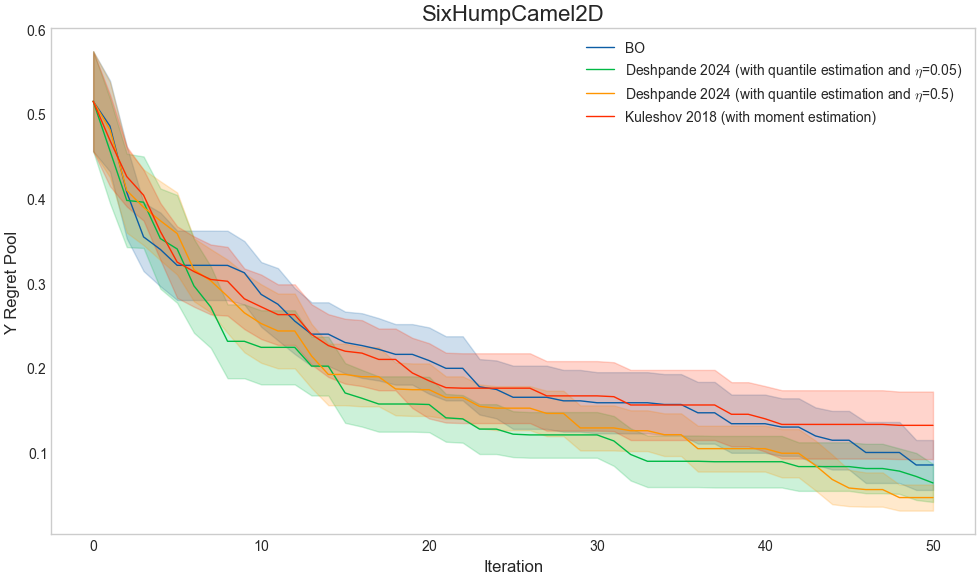

In [119]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='SixHumpCamel2D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/six_hump_camel_ucb_y_regret_pool.pdf'
)

Figure saved to ../figs/UCB/ackley_ucb_y_regret_pool.pdf


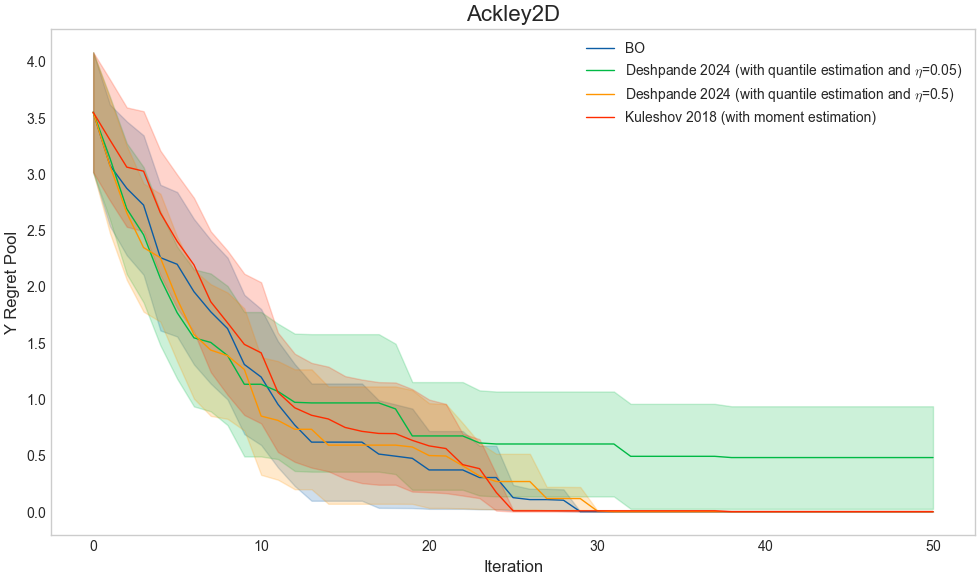

In [120]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Ackley2D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/ackley_ucb_y_regret_pool.pdf'
)

Figure saved to ../figs/UCB/forrester_ucb_y_regret_pool.pdf


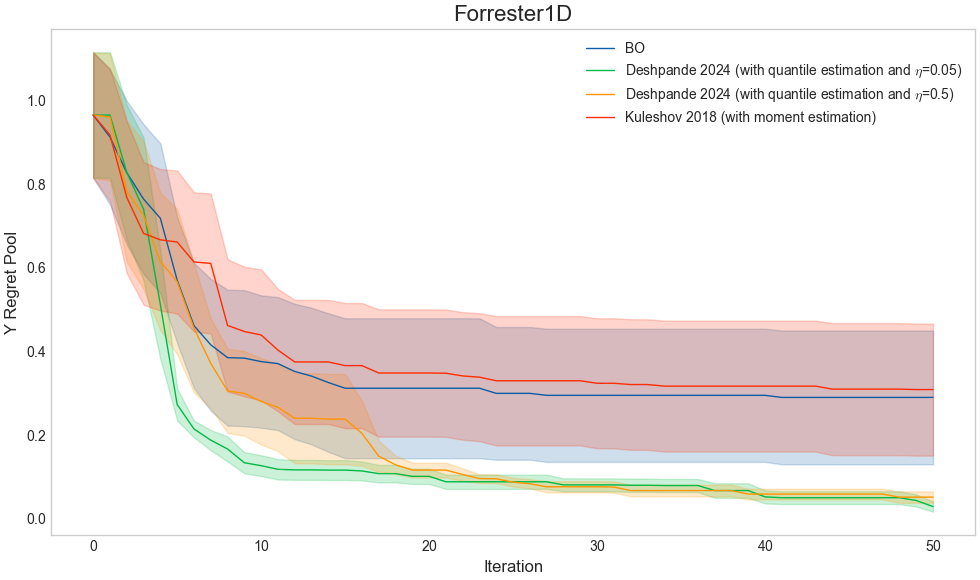

In [121]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Forrester1D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/forrester_ucb_y_regret_pool.pdf'
)

Figure saved to ../figs/UCB/sargan6D_ucb_y_regret_pool.pdf


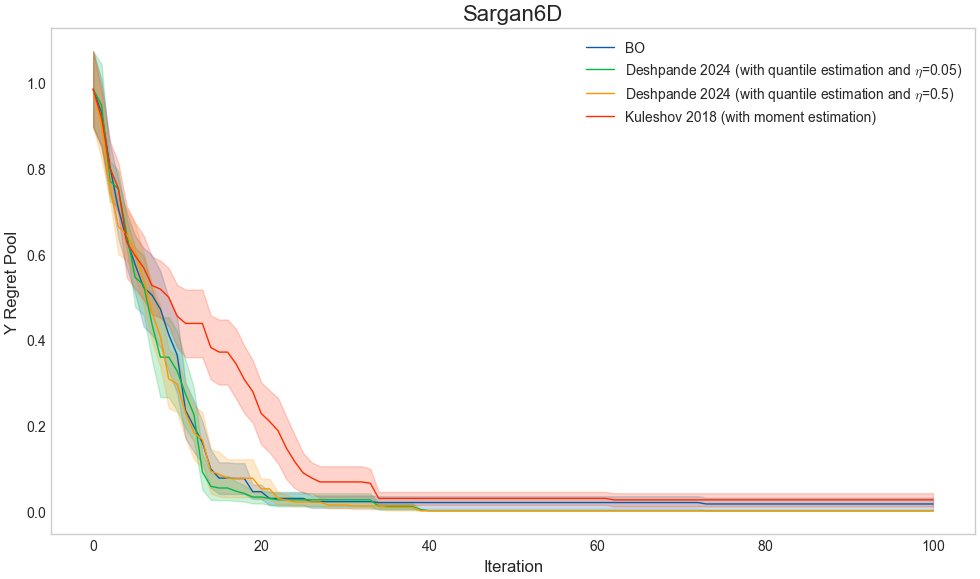

In [122]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Sargan6D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/sargan6D_ucb_y_regret_pool.pdf'
)

Figure saved to ../figs/EI/six_hump_camel_ei_y_regret_pool.pdf


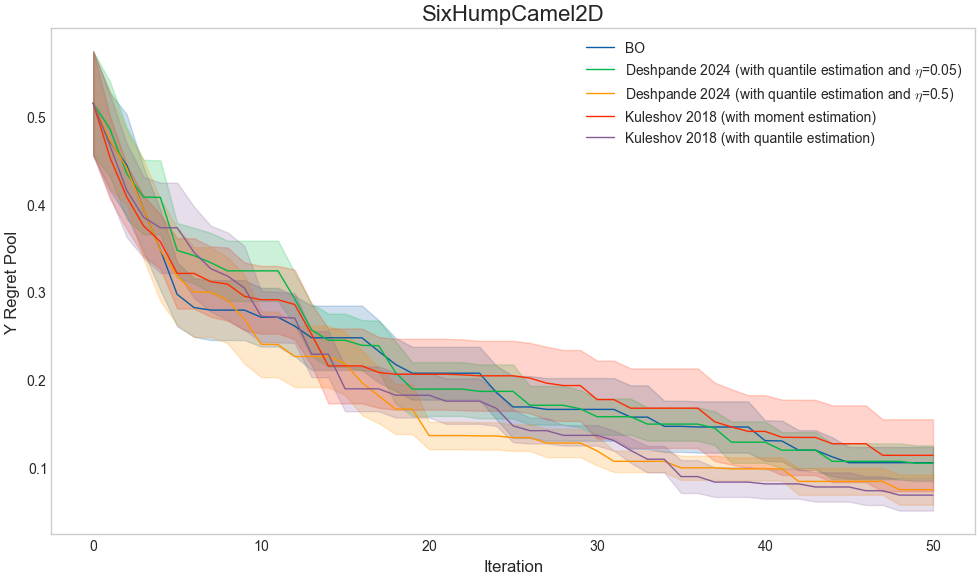

In [123]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='SixHumpCamel2D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/six_hump_camel_ei_y_regret_pool.pdf'
)

Figure saved to ../figs/EI/ackley_ei_y_regret_pool.pdf


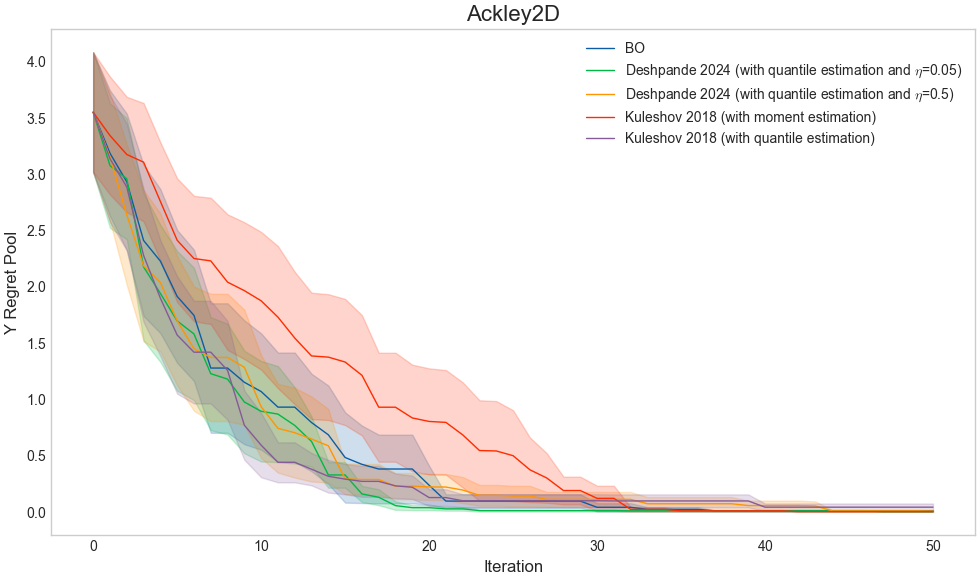

In [124]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Ackley2D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/ackley_ei_y_regret_pool.pdf'
)

Figure saved to ../figs/EI/forrester_ei_y_regret_pool.pdf


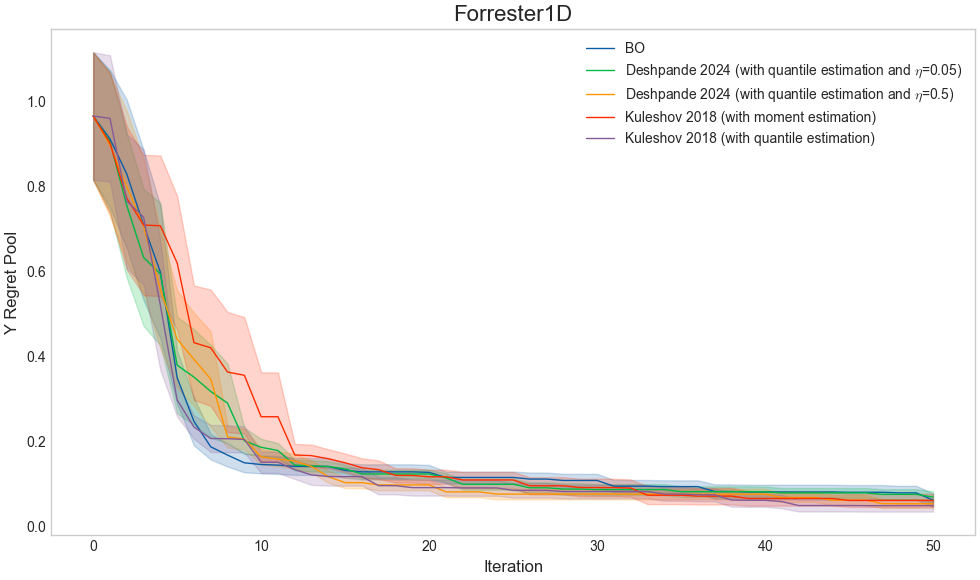

In [125]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Forrester1D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/forrester_ei_y_regret_pool.pdf'
)

Figure saved to ../figs/EI/sargan_ei_y_regret_pool.pdf


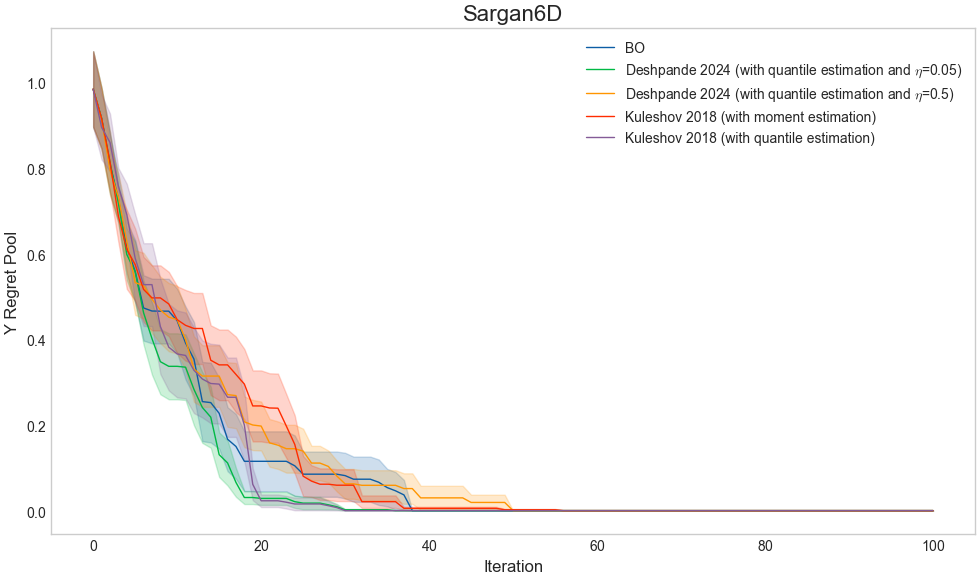

In [126]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Sargan6D', 
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/sargan_ei_y_regret_pool.pdf'
)

# ECE FIGURES

## UCB

Figure saved to ../figs/UCB/sargan_ucb_y_calibration_mse.pdf


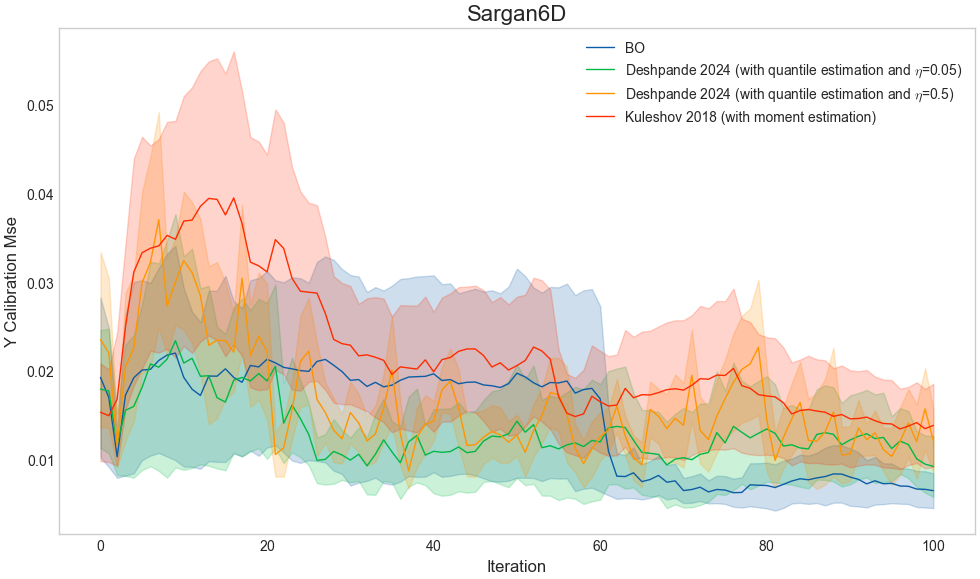

In [127]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Sargan6D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/sargan_ucb_y_calibration_mse.pdf'
)

Figure saved to ../figs/UCB/ackley_ucb_y_calibration_mse.pdf


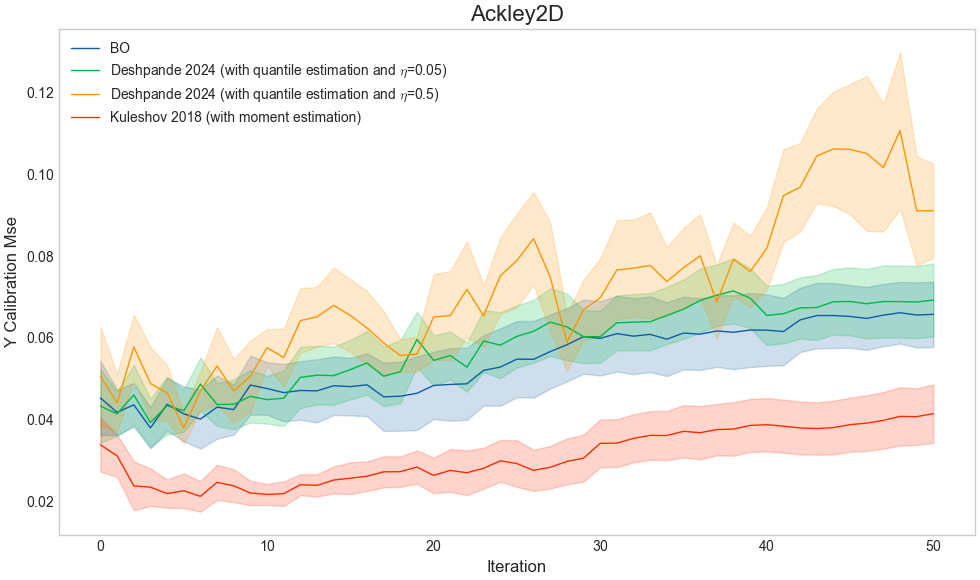

In [128]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Ackley2D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/ackley_ucb_y_calibration_mse.pdf'
)

Figure saved to ../figs/UCB/six_hump_camel_ucb_y_calibration_mse.pdf


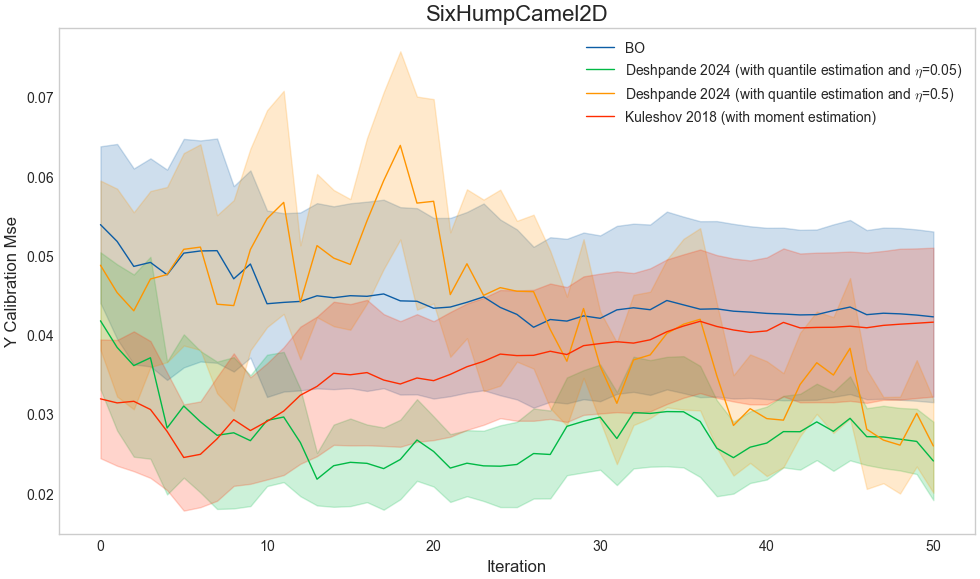

In [129]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='SixHumpCamel2D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/six_hump_camel_ucb_y_calibration_mse.pdf'
)

Figure saved to ../figs/UCB/forrester_ucb_y_calibration_mse.pdf


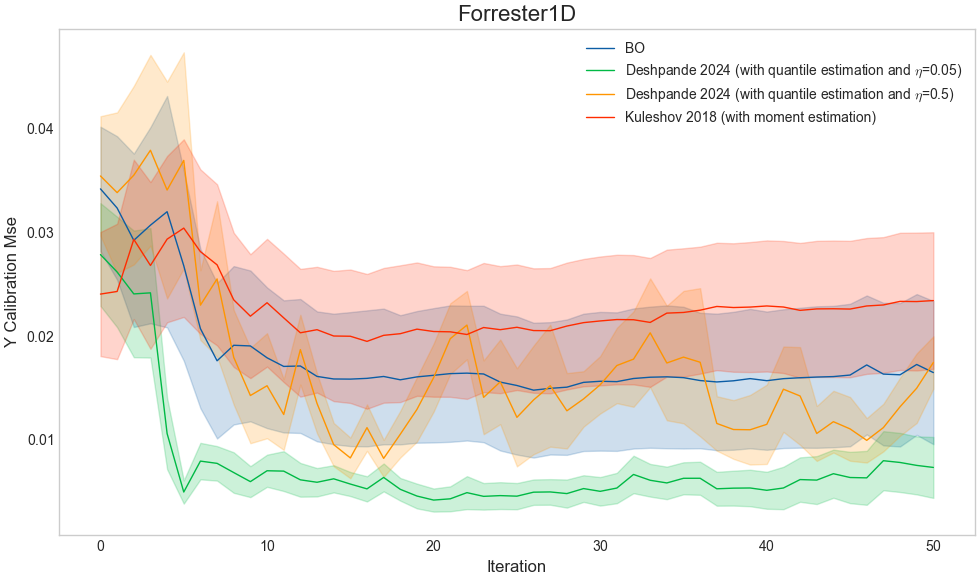

In [130]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Forrester1D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/forrester_ucb_y_calibration_mse.pdf'
)

## EI

Figure saved to ../figs/EI/forrester_ei_y_calibration_mse.pdf


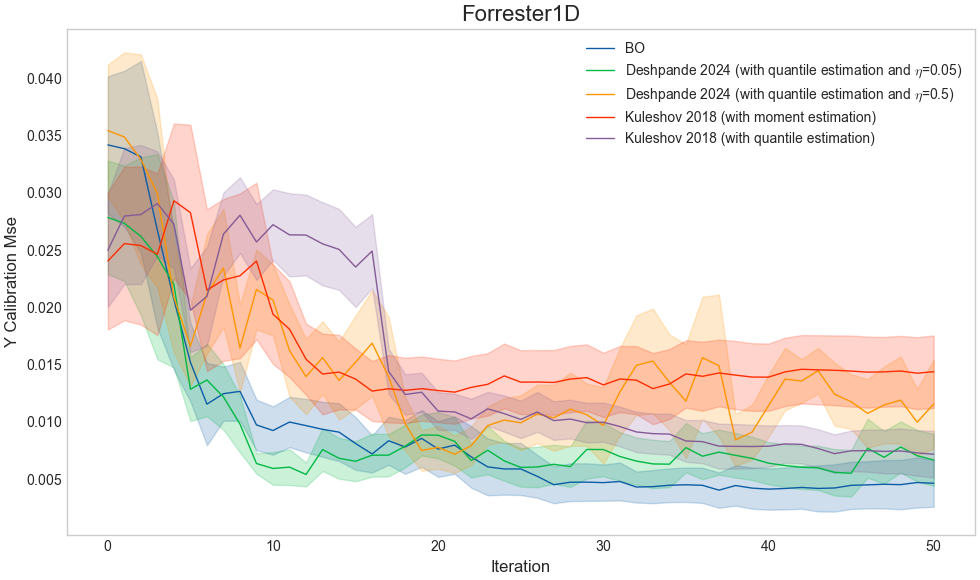

In [131]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Forrester1D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/forrester_ei_y_calibration_mse.pdf'
)

Figure saved to ../figs/EI/six_hump_camel_ei_y_calibration_mse.pdf


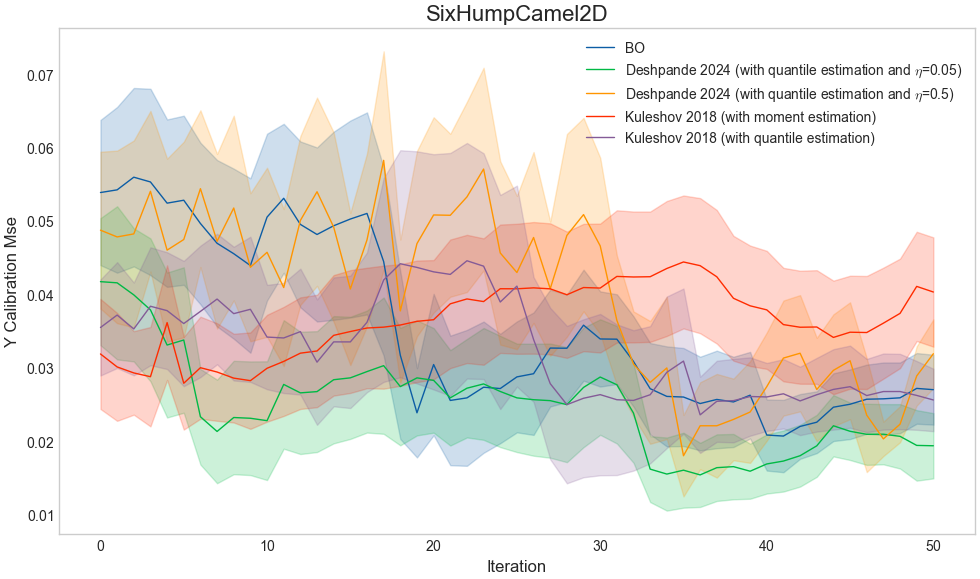

In [132]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='SixHumpCamel2D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/six_hump_camel_ei_y_calibration_mse.pdf'
)

Figure saved to ../figs/EI/ackley_ei_y_calibration_mse.pdf


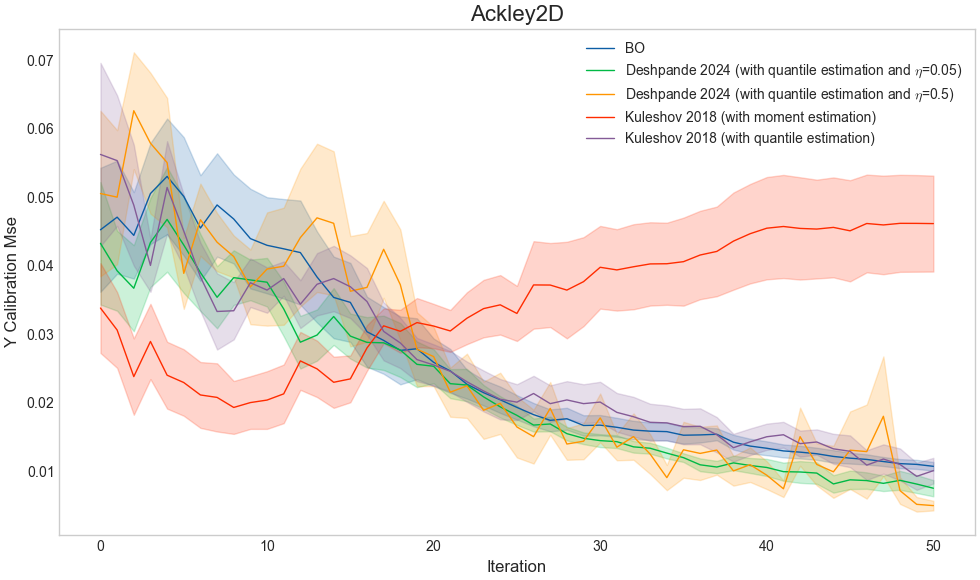

In [133]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Ackley2D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/ackley_ei_y_calibration_mse.pdf'
)

Figure saved to ../figs/EI/sargan_ei_y_calibration_mse.pdf


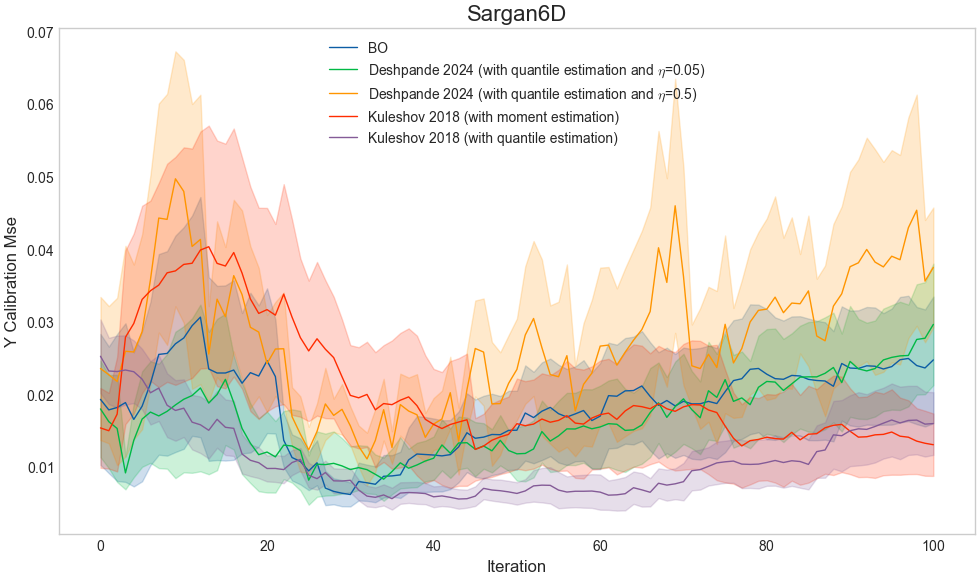

In [134]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Sargan6D', 
    metric='y_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/sargan_ei_y_calibration_mse.pdf'
)

# ONLINE CALIBRATION FIGURES

## UCB

Figure saved to ../figs/UCB/forrester_ucb_online_calibration_mse.pdf


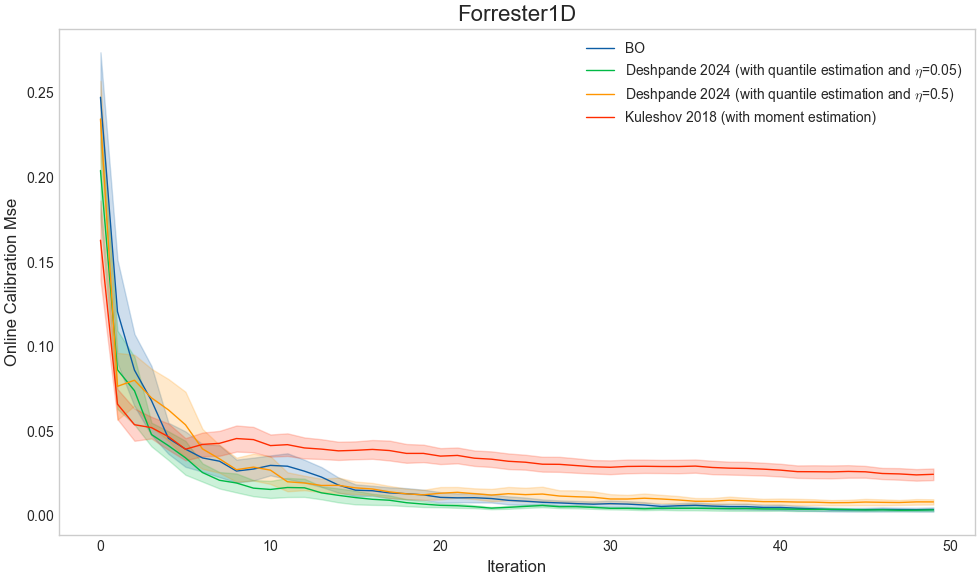

In [135]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Forrester1D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/forrester_ucb_online_calibration_mse.pdf'
)

Figure saved to ../figs/UCB/ackley_ucb_online_calibration_mse.pdf


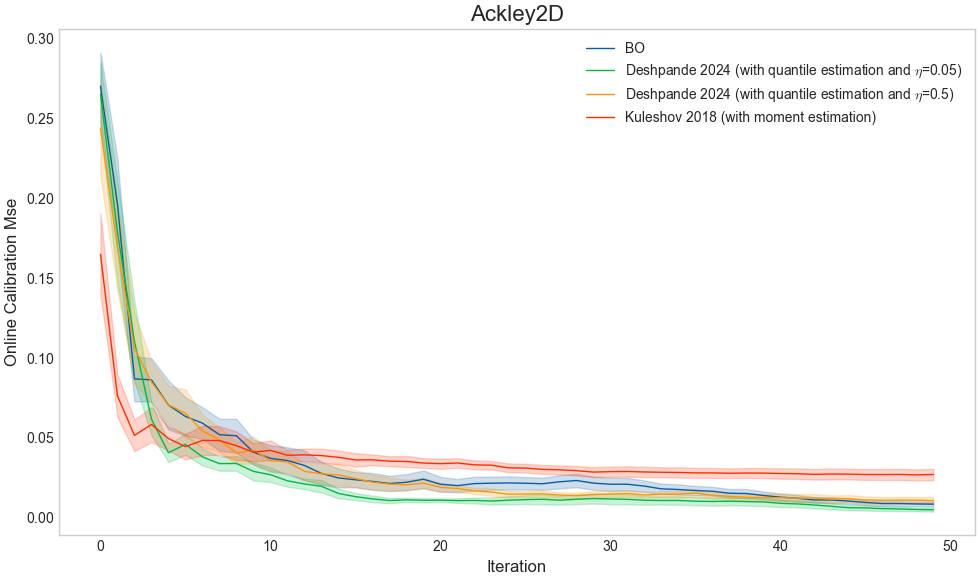

In [136]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Ackley2D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/ackley_ucb_online_calibration_mse.pdf'
)

Figure saved to ../figs/UCB/sargan_ucb_online_calibration_mse.pdf


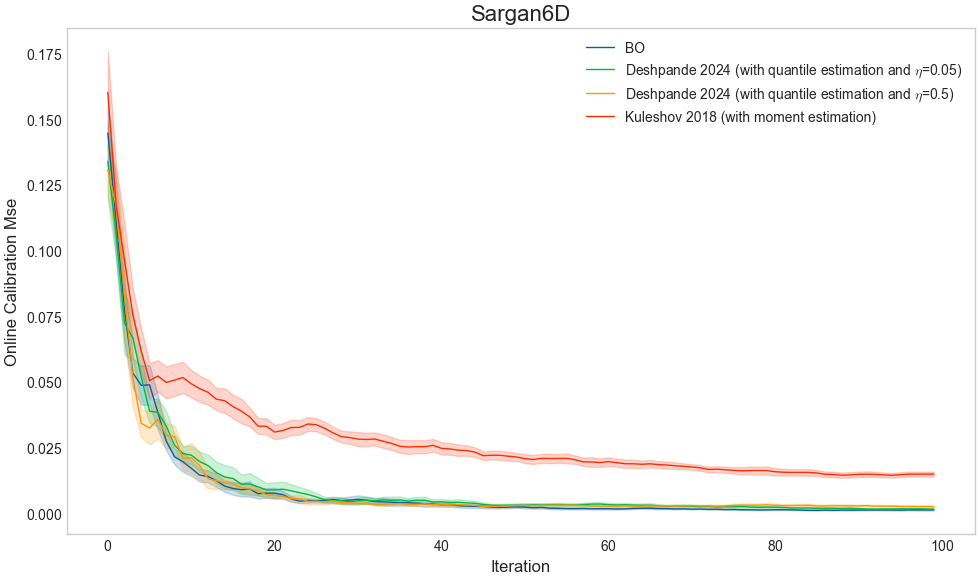

In [137]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Sargan6D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/sargan_ucb_online_calibration_mse.pdf'
)

Figure saved to ../figs/UCB/six_hump_camel_ucb_online_calibration_mse.pdf


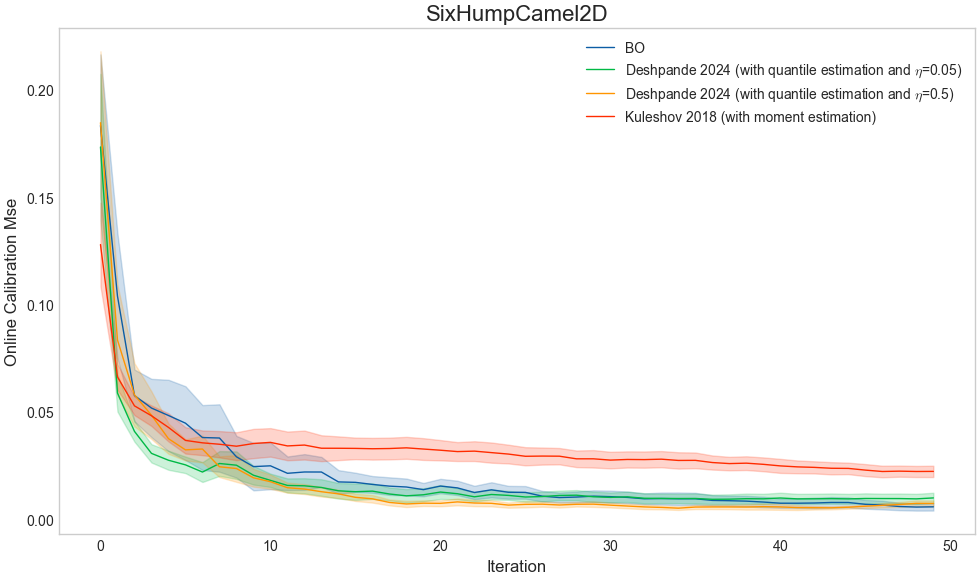

In [138]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='SixHumpCamel2D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/six_hump_camel_ucb_online_calibration_mse.pdf'
)

## EI

Figure saved to ../figs/EI/six_hump_camel_ei_online_calibration_mse.pdf


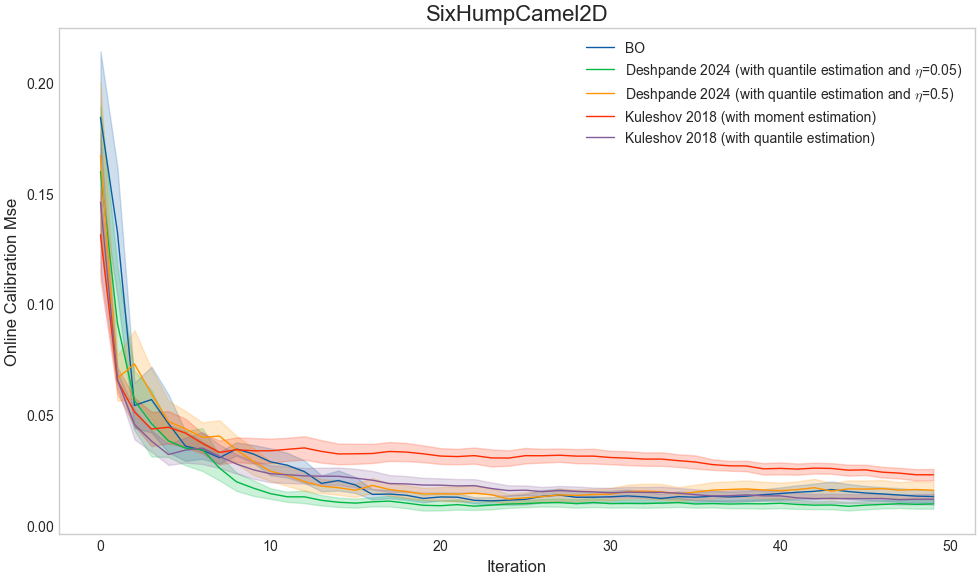

In [140]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='SixHumpCamel2D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/six_hump_camel_ei_online_calibration_mse.pdf'
)

Figure saved to ../figs/EI/ackley_ei_online_calibration_mse.pdf


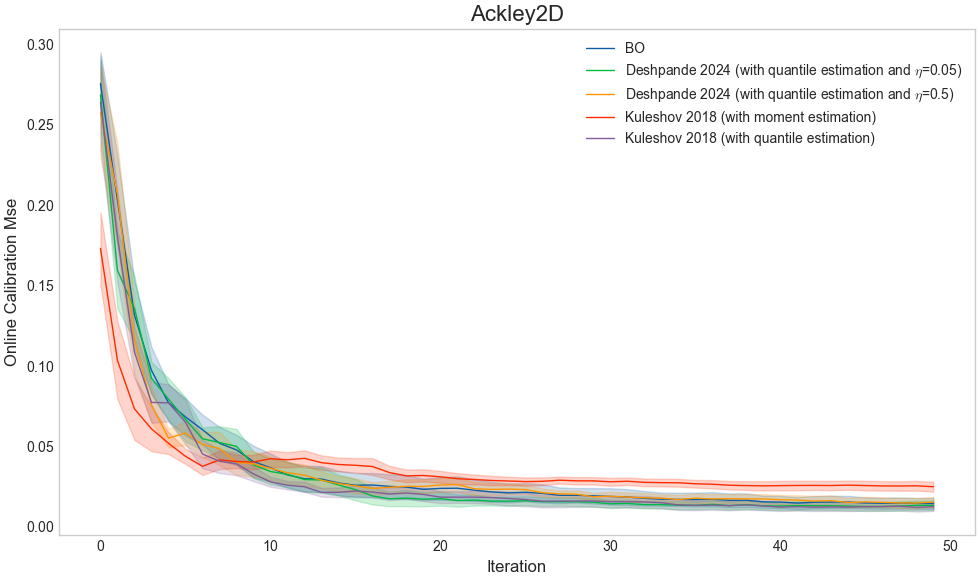

In [141]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Ackley2D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/ackley_ei_online_calibration_mse.pdf'
)

Figure saved to ../figs/EI/forrester_ei_online_calibration_mse.pdf


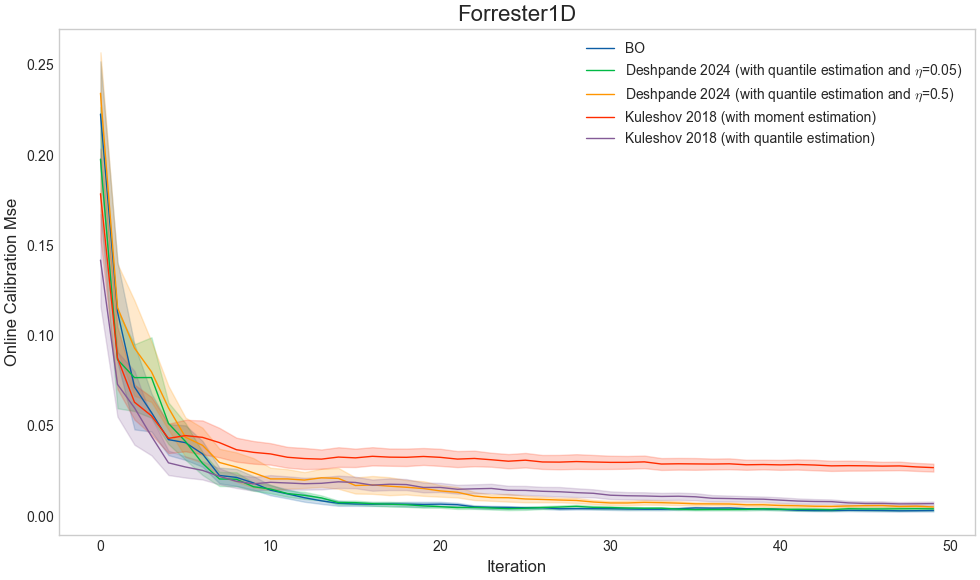

In [142]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Forrester1D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/forrester_ei_online_calibration_mse.pdf'
)

Figure saved to ../figs/EI/sargan_ei_online_calibration_mse.pdf


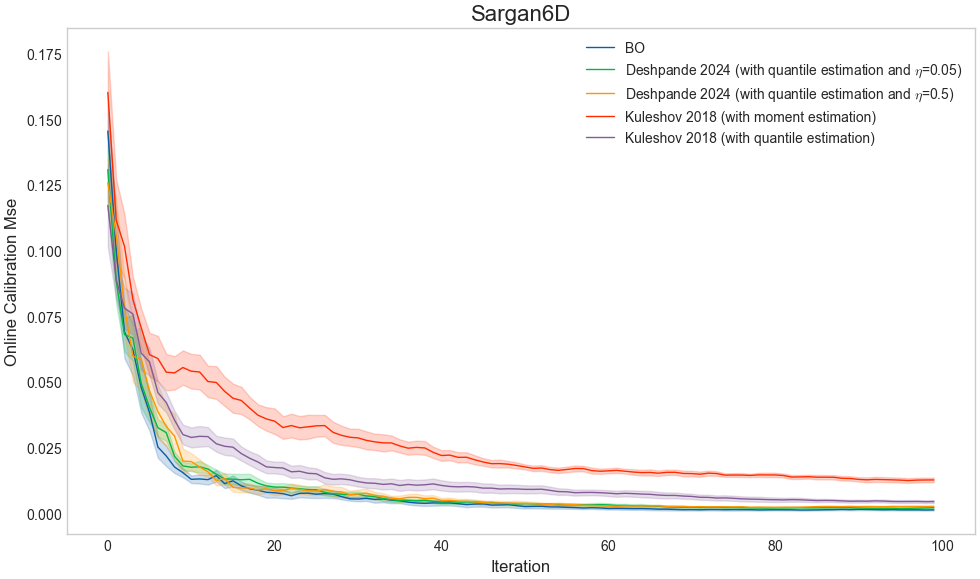

In [143]:
plot_metric_comparison(
    aggregated_df_ei, 
    problem_name='Sargan6D', 
    metric='online_calibration_mse',
    n_initial=5,
    noisify=True,
    acquisition="EI",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/EI/sargan_ei_online_calibration_mse.pdf'
)

# NEGATIVE ENTROPY FIGURES

## UCB

Figure saved to ../figs/UCB/forrester_ucb_mean_sharpness.pdf


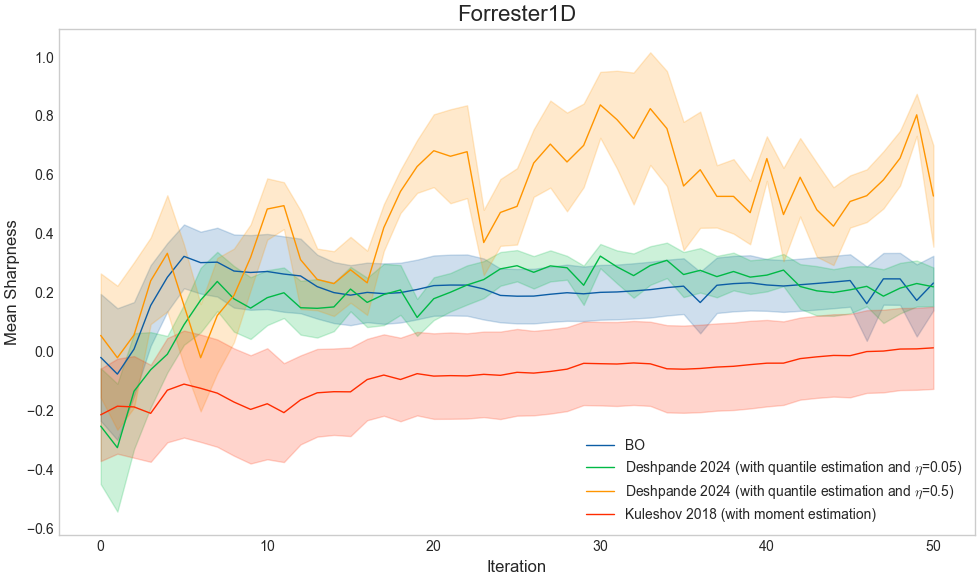

In [146]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Forrester1D', 
    metric='mean_sharpness',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/forrester_ucb_mean_sharpness.pdf'
)

Figure saved to ../figs/UCB/ackley_ucb_mean_sharpness.pdf


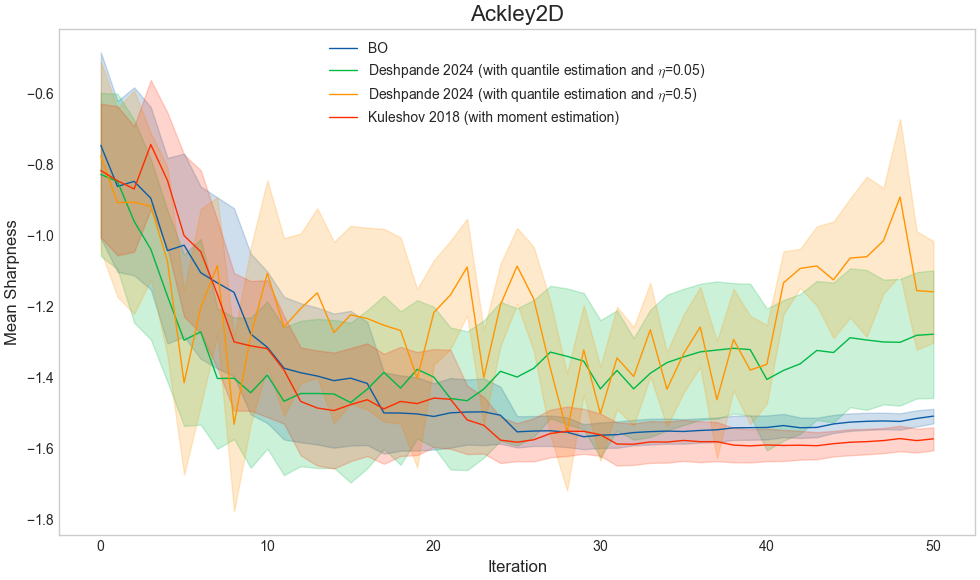

In [147]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Ackley2D', 
    metric='mean_sharpness',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/ackley_ucb_mean_sharpness.pdf'
)

Figure saved to ../figs/UCB/six_hump_camel_ucb_mean_sharpness.pdf


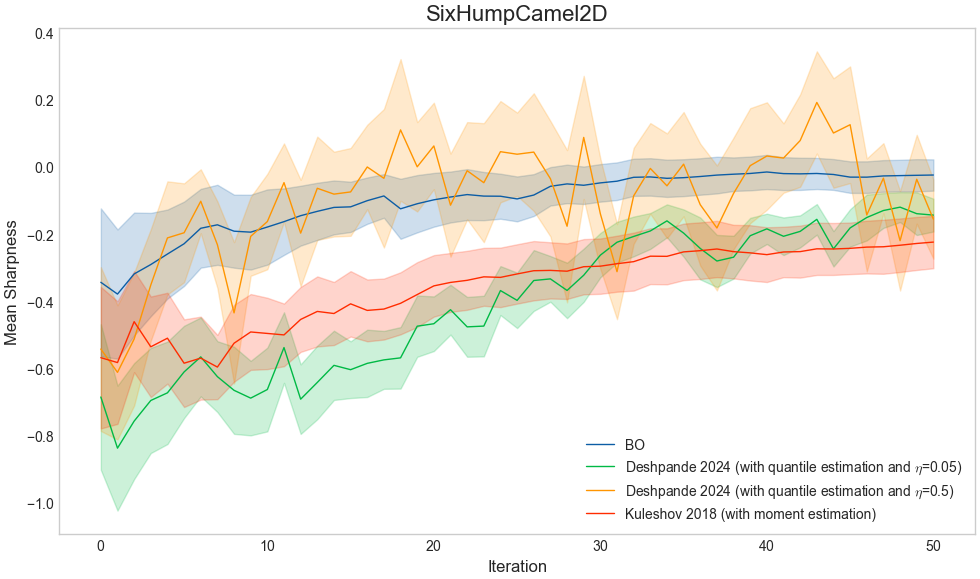

In [148]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='SixHumpCamel2D', 
    metric='mean_sharpness',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/six_hump_camel_ucb_mean_sharpness.pdf'
)

Figure saved to ../figs/UCB/sargan_ucb_mean_sharpness.pdf


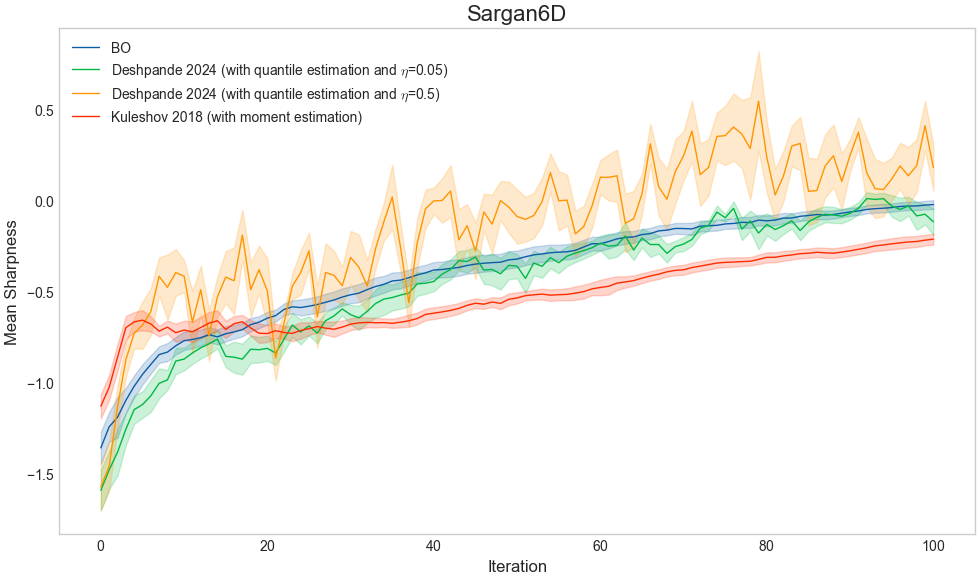

In [149]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Sargan6D', 
    metric='mean_sharpness',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/sargan_ucb_mean_sharpness.pdf'
)

## EI

## POSTERIOR VARIANCE FIGURES

## UCB

Figure saved to ../figs/UCB/forrester_ucb_posterior_variance.pdf


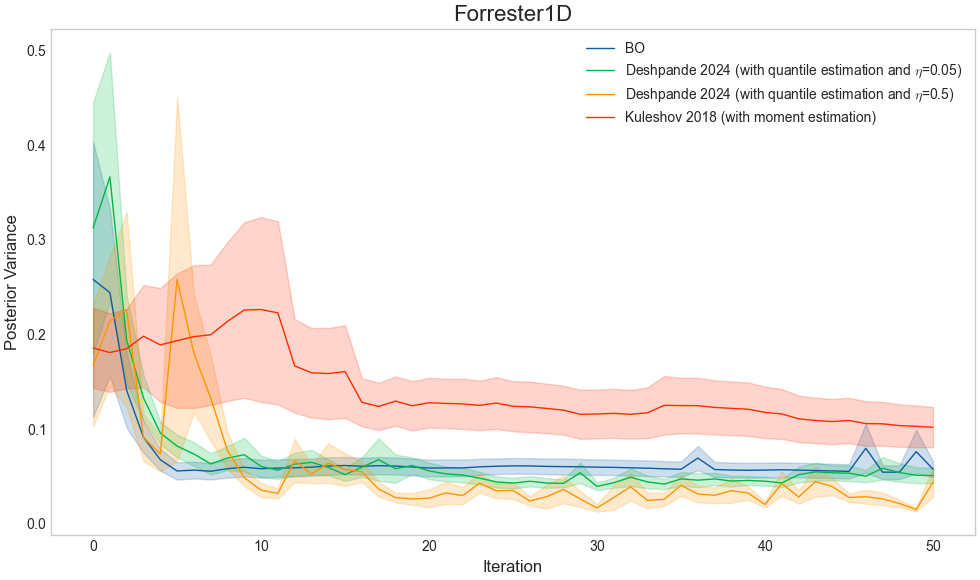

In [150]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Forrester1D', 
    metric='posterior_variance',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/forrester_ucb_posterior_variance.pdf'
)

Figure saved to ../figs/UCB/ackley_ucb_posterior_variance.pdf


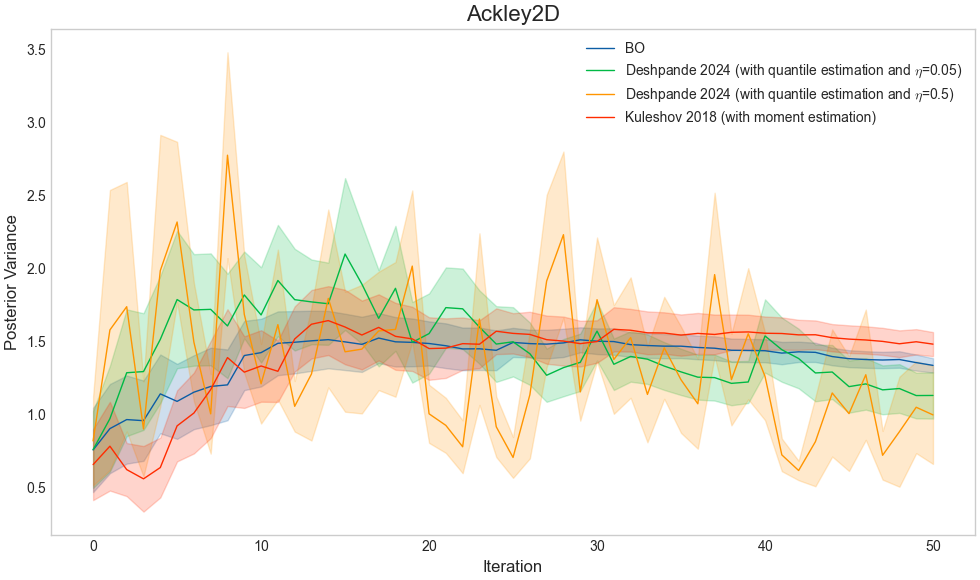

In [151]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Ackley2D', 
    metric='posterior_variance',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/ackley_ucb_posterior_variance.pdf'
)

Figure saved to ../figs/UCB/six_hump_camel_ucb_posterior_variance.pdf


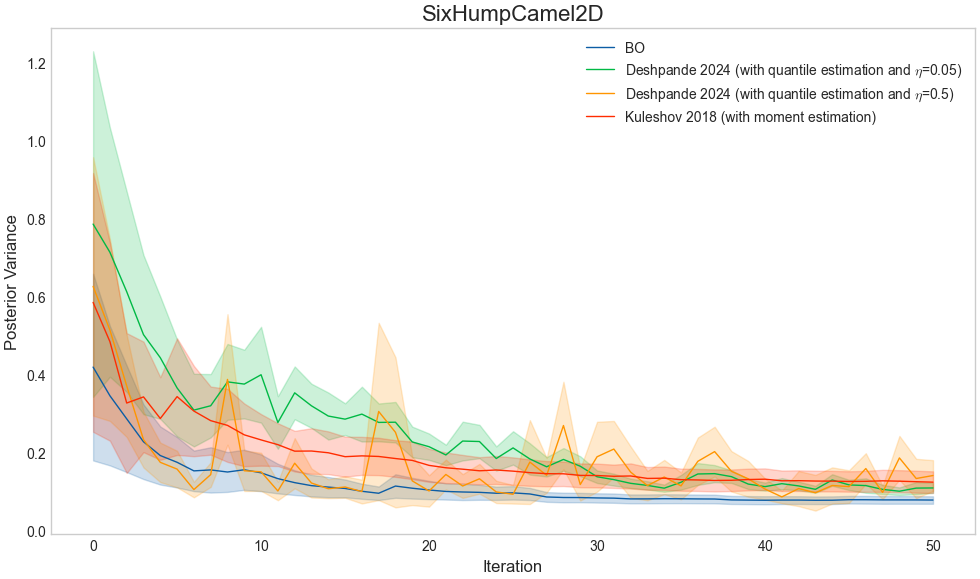

In [152]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='SixHumpCamel2D', 
    metric='posterior_variance',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/six_hump_camel_ucb_posterior_variance.pdf'
)

# CRPS FIGURES

## UCB

Figure saved to ../figs/UCB/six_hump_camel_ucb_crps_test.pdf


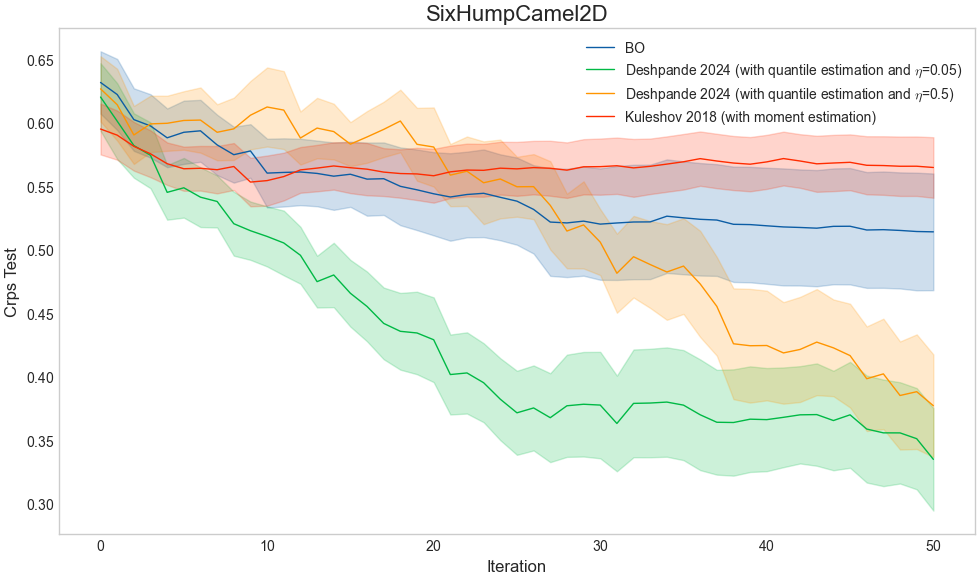

In [153]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='SixHumpCamel2D', 
    metric='crps_test',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/six_hump_camel_ucb_crps_test.pdf'
)

Figure saved to ../figs/UCB/forrester_ucb_crps_test.pdf


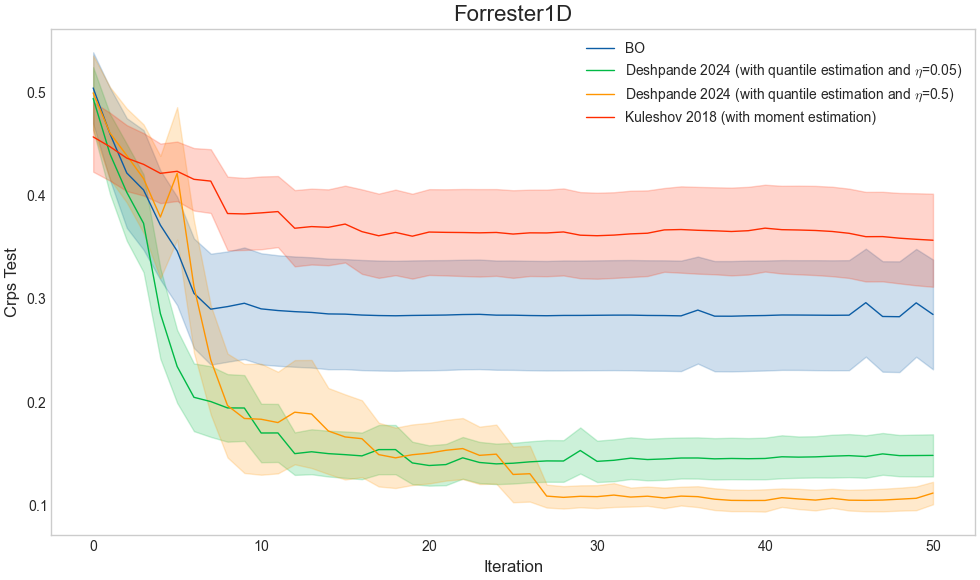

In [154]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Forrester1D', 
    metric='crps_test',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/forrester_ucb_crps_test.pdf'
)

Figure saved to ../figs/UCB/ackley_ucb_crps_test.pdf


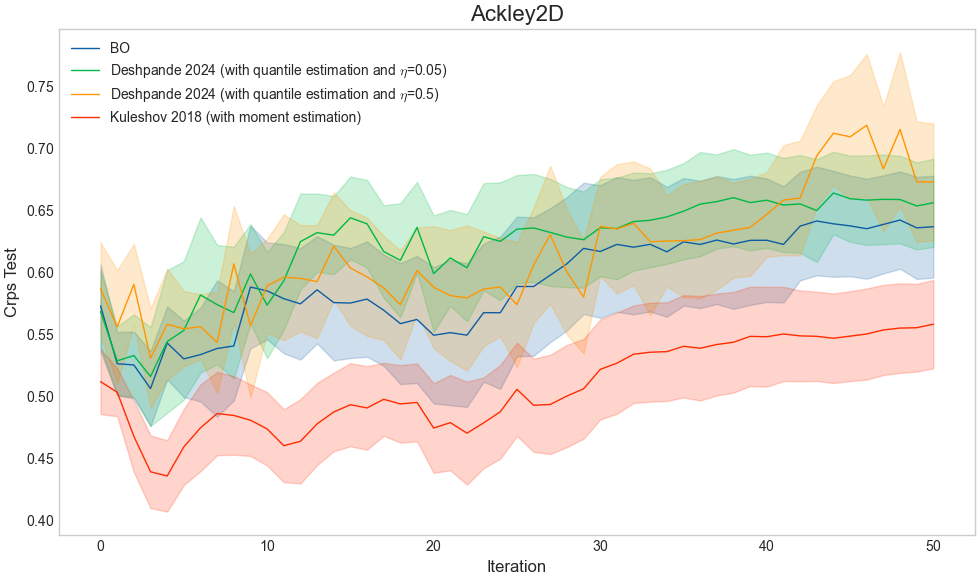

In [155]:
plot_metric_comparison(
    aggregated_df_ucb, 
    problem_name='Ackley2D', 
    metric='crps_test',
    n_initial=5,
    noisify=True,
    acquisition="UCB",
    methods_to_plot=['None', 'ONLINEv2_e05', 'ONLINEv2_e005', 'UNIBOv2', 'UNIBOv1'],
    save_path='../figs/UCB/ackley_ucb_crps_test.pdf'
)

# SUMMARY STATISTICS

In [159]:
from scipy.stats import sem # Standard Error of the Mean

def calculate_summary_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates summary statistics for experiment results across different seeds.

    This function aggregates results by experiment configuration and computes the
    mean and standard error for key performance indicators like regret, 
    calibration error (ECE), and sharpness.

    Args:
        df: A pandas DataFrame created by the `load_all_results` function, 
            where each row corresponds to a single seed of an experiment.

    Returns:
        A pandas DataFrame where each row contains the summary statistics for one
        unique experiment configuration.
    """
    if df.empty:
        print("Input DataFrame is empty. Returning an empty DataFrame.")
        return pd.DataFrame()

    # Define the columns that uniquely identify an experiment
    grouping_keys = [
        'problem', 'surrogate', 'acquisition', 'quantile_level',
        'n_initial', 'method', 'noisify'
    ]

    # Ensure all grouping keys are present in the DataFrame
    missing_keys = [key for key in grouping_keys if key not in df.columns]
    if missing_keys:
        print(f"Error: Missing grouping keys in DataFrame: {missing_keys}")
        return pd.DataFrame()

    print("Calculating summary statistics across seeds...")

    # Group by the experiment identifiers
    grouped = df.groupby(grouping_keys)

    # --- Helper function to apply to each group ---
    def summarize_group(group):
        """Processes a single group (all seeds for one experiment)."""
        
        # --- 1. Regret Statistics ---
        # Cumulative Regret: Sum of instantaneous regret over all iterations for each seed.
        cum_regret_per_seed = group['y_regret_pool'].apply(np.sum)
        # Best Instantaneous Regret: The best (minimum) regret achieved at any iteration for each seed.
        best_regret_per_seed = group['y_regret_pool'].apply(np.min)

        # --- 2. ECE (Expected Calibration Error) Statistics from 'uct_calibration' ---
        # Final ECE: The ECE value at the final iteration for each seed.
        final_ece_per_seed = group['uct_calibration'].apply(lambda x: x[-1] if x else np.nan)
        # Best ECE: The best (minimum) ECE value achieved at any iteration for each seed.
        best_ece_per_seed = group['uct_calibration'].apply(lambda x: np.min(x) if x else np.nan)
        
        # --- 3. Sharpness Statistics from 'uct_sharpness' ---
        # Final Sharpness: The sharpness value at the final iteration for each seed.
        final_sharpness_per_seed = group['uct_sharpness'].apply(lambda x: x[-1] if x else np.nan)
        # Best Sharpness: The best (minimum) sharpness value achieved at any iteration for each seed.
        best_sharpness_per_seed = group['uct_sharpness'].apply(lambda x: np.min(x) if x else np.nan)

        # --- 4. Assemble the results into a dictionary ---
        summary = {
            'cumulative_regret_mean': cum_regret_per_seed.mean(),
            'cumulative_regret_sem': sem(cum_regret_per_seed, nan_policy='omit'),
            
            'best_instant_regret_mean': best_regret_per_seed.mean(),
            'best_instant_regret_sem': sem(best_regret_per_seed, nan_policy='omit'),
            
            'final_ece_mean': final_ece_per_seed.mean(),
            'final_ece_sem': sem(final_ece_per_seed, nan_policy='omit'),
            
            'best_ece_mean': best_ece_per_seed.mean(),
            'best_ece_sem': sem(best_ece_per_seed, nan_policy='omit'),
            
            'final_sharpness_mean': final_sharpness_per_seed.mean(),
            'final_sharpness_sem': sem(final_sharpness_per_seed, nan_policy='omit'),
            
            'best_sharpness_mean': best_sharpness_per_seed.mean(),
            'best_sharpness_sem': sem(best_sharpness_per_seed, nan_policy='omit'),
        }
        return pd.Series(summary)

    # Apply the summary function to each group and reset the index to turn group keys back into columns
    summary_df = grouped.apply(summarize_group).reset_index()
    
    print("Summary statistics calculation complete.")
    return summary_df

# --- Example Usage ---
# Make sure you have the other functions (parse_experiment_name, load_all_results) defined.
#
# 1. Load the raw data from all JSON files
# raw_results_df = load_all_results(base_path="results_synth_data")
#
# 2. Calculate the summary statistics
# if not raw_results_df.empty:
#     summary_table = calculate_summary_statistics(raw_results_df)
#     print("\nGenerated Summary Table:")
#     print(summary_table.head())